In [1]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
bins = np.arange(11)
bin_cents = (bins[1:]+bins[:-1])/2

hist1 = np.array([1.5, 3., 6., 7.5, 6.3, 6.6, 5.5, 2.5, 3. , 1.5])
hist1_err = np.array([0.4 , 0.4 , 0.3 , 0.2 , 0.15, 0.4 , 0.45, 0.5 , 0.3 , 0.35])
hist2 = np.array([3. , 6., 9., 12., 15., 9. , 6., 3. , 3.3, 2.15])
hist2_err = np.array([1. , 1. , 3. , 2. , 2., 1. , 2., 2. , 1. , 1.])


data = np.array([ 4, 17, 26, 23, 34, 23, 21,  7,  8,  4])

In [3]:
samples = [
    {
        "name": "sample1",
        "data": list(hist2/2),
        "modifiers": [
            {"name": "mu1", "type": "normfactor", "data" : None},
            {
                "name": "hun1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2/2 - hist1/2),
                    "hi_data": list(hist2/2 + hist1/2)
                }
            }
        ],
    },
    {
        "name": "sample2",
        "data": list(hist2/2),
        "modifiers": [
            {"name": "mu2", "type": "normfactor", "data" : None},
            {
                "name": "hun1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2/2 - hist1/2),
                    "hi_data": list(hist2/2 + hist1/2)
                }
            }
        ],
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}

# info: the `poi_name=None` is nescessary here since we don't want to do a hypothesis test
model = pyhf.Model(spec, poi_name=None)

[1, 1.0, 1.0]


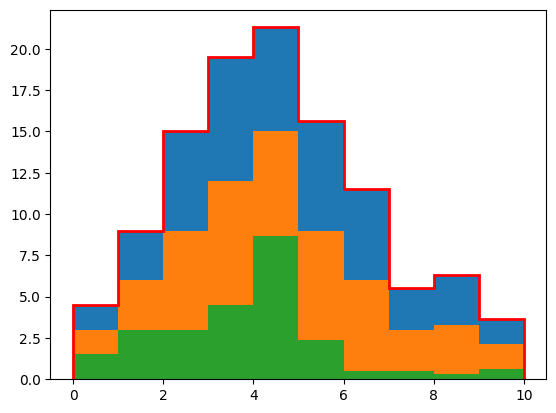

In [4]:
plt.stairs(hist1+hist2, bins, baseline=hist2, fill = True)
plt.stairs(hist2, bins, fill=True)
plt.stairs(hist2-hist1, bins, fill=True)


initial_parameters = model.config.suggested_init()
initial_parameters[0] = 1
# initial_parameters[1] = 1

plt.stairs(model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')
# plt.errorbar(bin_cents, model.config.auxdata, yerr=np.sqrt(model.config.auxdata), fmt='o')
print(initial_parameters)


In [78]:
from copy import deepcopy

def _pca(corr, return_rot=False):
    """Principal Component analysis, moving to a space where the covariance matrix is diagonal
    https://www.cs.cmu.edu/~elaw/papers/pca.pdf

    Args:
        cov (array): Correlation matrix

    Returns:
        array: matrix of column wise error vectors (eigenvectors * sqrt(eigenvalues); sqrt(eigenvalues) = std)
    """
    svd = np.linalg.svd(corr)
    uvec = svd[0] @ np.sqrt(np.diag(svd[1]))
    if return_rot:
        return uvec, svd[0]
    return uvec

def validate(corr):
    for c in corr:
        shape = np.shape(c["corr"])
        if len(shape) != 2:
            raise ValueError("Correlation matrix must be 2-dimensional.")
        if shape[0] != shape[1]:
            raise ValueError("Correlation matrix must be square.")
        if len(c["vars"]) != len(c["corr"]):
            raise ValueError("Number of variables does not match dimension of correlation matrix")
        
        
def get_coords(var_name, spec):
    for ich, ch in enumerate(spec):
        for isa, sa in enumerate(ch["samples"]):
            for imo, mo in enumerate(sa["modifiers"]):
                if mo["name"] == var_name:
                    return ich, isa, imo
    

def decorrelate(spec):
    if "correlations" in spec.keys():
        print("correlation found")
        
        validate(spec["correlations"])
        
        spec = deepcopy(spec)
        
        for corr in spec["correlations"]:
            
            # compute decorrelation 
            uvec = _pca(corr["corr"])
            
            # get channel, sample and modifier index for each variable
            coords = []
            for var in corr["vars"]:
                coords.append(get_coords(var, spec["channels"]))
            print(coords)
            
            ich = coords[0][0]
            isa = coords[0][1]
            imo = [c[2] for c in coords]
            mod_type = spec["channels"][ich]["samples"][isa]["modifiers"][imo[0]]["type"]
            
            # check if all vars in one channel, sample
            for co in coords:
                if co[0] != ich or co[1] != isa:
                    raise ValueError("All variables must be in the same channel and sample.")
            
            #check if all modifiers have the same type
            for i in imo:
                if spec["channels"][ich]["samples"][isa]["modifiers"][i]["type"] != mod_type:
                    raise ValueError("All modifiers must have the same type.")
                
            nom = spec["channels"][ich]["samples"][isa]["data"]
            lo_shifts = [np.subtract(spec["channels"][ich]["samples"][isa]["modifiers"][i]["data"]["lo_data"], nom) for i in imo]
            hi_shifts = [np.subtract(spec["channels"][ich]["samples"][isa]["modifiers"][i]["data"]["hi_data"], nom) for i in imo]
            
            # compute new high and low modifications for eigenvector
            for i, uv in enumerate(uvec.T):
                new_lo = np.sum(
                    [nom] + [np.multiply(u, s) for u, s in zip(uv, lo_shifts)],
                    axis=0
                )

                new_hi = np.sum(
                    [nom] + [np.multiply(u, s) for u, s in zip(uv, hi_shifts)],
                    axis=0
                )
                
                #add new modifier
                spec["channels"][ich]["samples"][isa]["modifiers"].append(
                    {
                        "name": corr["name"]+str(i),
                        "type": mod_type,
                        "data": {
                            "lo_data": list(new_lo),
                            "hi_data": list(new_hi)
                        }
                    }
                )
            
            #rm old modifier
            new_modifiers = []
            for m in spec["channels"][0]["samples"][0]["modifiers"]:
                if m["name"] not in corr["vars"]:
                    new_modifiers.append(m)
        
        spec["channels"][ich]["samples"][isa]["modifiers"] = new_modifiers
        
        del spec["correlations"]
        
    return spec

In [79]:
# add correlated parameters to pyhf model
samples = [
    {
        "name": "sample1",
        "data": list(hist2),
        "modifiers": [
            {"name": "mu", "type": "normfactor", "data" : None},
            {
                "name": "u1",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist1),
                    "hi_data": list(hist2+hist1)
                }
            },
            {
                "name": "u2",
                "type": "histosys",
                "data": {
                    "lo_data": list(hist2-hist2),
                    "hi_data": list(hist2+hist2)
                }
            }
        ],
        
    },
]
spec = {"channels" : [{"name" : "singlechannel", "samples" : samples}]}
model = pyhf.Model(spec)


In [80]:
spec = {
    "channels" : [{"name" : "singlechannel", "samples" : samples}], 
    "correlations": [
        {
            "name": "corr",
            "vars": ["u1", "u2"],
            "corr": [[1., 1.], [1., 1.]],
        }
    ]}
new_spec = decorrelate(spec)
new_model = pyhf.Model(new_spec)
new_spec

correlation found
[(0, 0, 1), (0, 0, 2)]


{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'sample1',
     'data': [3.0, 6.0, 9.0, 12.0, 15.0, 9.0, 6.0, 3.0, 3.3, 2.15],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'corr0',
       'type': 'histosys',
       'data': {'lo_data': [7.5,
         15.0,
         24.0,
         31.499999999999996,
         36.3,
         24.599999999999998,
         17.5,
         8.5,
         9.599999999999998,
         5.799999999999999],
        'hi_data': [-1.4999999999999996,
         -2.999999999999999,
         -5.999999999999998,
         -7.499999999999997,
         -6.299999999999999,
         -6.599999999999998,
         -5.499999999999998,
         -2.499999999999999,
         -2.999999999999999,
         -1.4999999999999996]}},
      {'name': 'corr1',
       'type': 'histosys',
       'data': {'lo_data': [3.0,
         6.0,
         9.0,
         12.0,
         15.0,
         9.0,
         6.0,
         3.0,
         3.3,
         

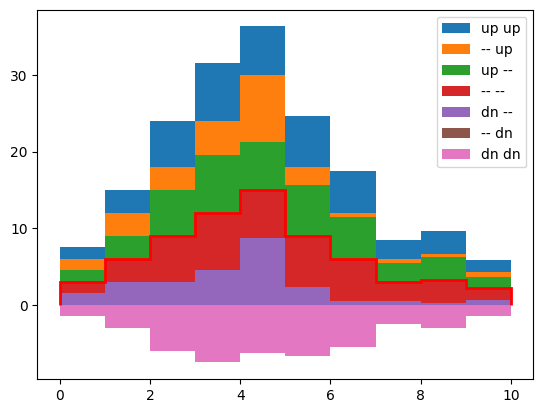

In [83]:
plt.stairs(hist2+hist1+hist2, bins, fill = True, label = 'up up')
plt.stairs(hist2+hist2, bins, fill = True, label = '-- up')
plt.stairs(hist2+hist1, bins, fill = True, label = 'up --')
plt.stairs(hist2, bins, fill=True, label = '-- --')
plt.stairs(hist2-hist1, bins, fill=True, label = 'dn --')
plt.stairs(hist2-hist2, bins, fill=True, label = '-- dn')
plt.stairs(hist2-hist1-hist2, bins, fill=True, label = 'dn dn')

initial_parameters = new_model.config.suggested_init()
initial_parameters[0] = 0.
initial_parameters[1] = 0.

plt.stairs(new_model.expected_data(initial_parameters, include_auxdata=False), bins, linewidth=2, color='r')

plt.legend()